In [4]:
import numpy as np
import random
import math
from sklearn.metrics import confusion_matrix, classification_report

UNK = "<UNK>"
threshold = 2
train_ratio = 0.8
k_smoothing = 0.001

def split_data(filepath, train_ratio=0.8):
    with open(filepath, "r") as f:
        lines = f.readlines()
    random.shuffle(lines)
    
    # Filter out sentences with 2 or fewer words
    lines = [line for line in lines if len(line.strip().split()) > 1]
    
    split_point = int(len(lines) * train_ratio)
    return lines[:split_point], lines[split_point:]

def count_ngrams(lines):
    unigram_count = {UNK: 0}
    bigram_count = {}
    for line in lines:
        tokens = line.strip().split()
        for i, token in enumerate(tokens):
            unigram_count[token] = unigram_count.get(token, 0) + 1
            if i > 0:
                bigram = (tokens[i - 1], token)
                bigram_count[bigram] = bigram_count.get(bigram, 0) + 1
    return unigram_count, bigram_count

def prune_ngrams(unigram_count, bigram_count, threshold):
    for token, count in list(unigram_count.items()):
        if count < threshold and token != UNK:
            unigram_count[UNK] += count
            del unigram_count[token]

    for bigram, count in list(bigram_count.items()):
        w1, w2 = bigram
        new_bigram = (
            w1 if w1 in unigram_count else UNK,
            w2 if w2 in unigram_count else UNK
        )
        if new_bigram != bigram:
            bigram_count[new_bigram] = bigram_count.get(new_bigram, 0) + count
            del bigram_count[bigram]

    return unigram_count, bigram_count

def sentence_log_prob(sentence, unigram_count, bigram_count, total_unigrams, vocab_size, k=0.001):
    log_prob = 0.0
    for i in range(1, len(sentence)):
        w1 = sentence[i - 1] if sentence[i - 1] in unigram_count else UNK
        w2 = sentence[i] if sentence[i] in unigram_count else UNK
        count_unigram = unigram_count.get(w1, 0)
        count_bigram = bigram_count.get((w1, w2), 0)
        # Calculate smoothed probability for the bigram
        prob = (count_bigram + k) / (count_unigram + k * vocab_size)
        log_prob += math.log(prob)
    
    # Convert log_prob back to probability using exponentiation
    # Use max(1e-10, prob) to avoid numerical issues (values too small to compute reliably)
    prob = math.exp(log_prob) if log_prob != float("-inf") else 0.0
    return max(prob, 1e-10)  # Ensure a small minimum probability to avoid 0.0

def build_model(lines, threshold):
    unigram_count, bigram_count = count_ngrams(lines)
    unigram_count, bigram_count = prune_ngrams(unigram_count, bigram_count, threshold)
    total_unigrams = sum(unigram_count.values())
    vocab_size = len(unigram_count)
    return unigram_count, bigram_count, total_unigrams, vocab_size

# Split datasets (now filtering out sentences with 2 or fewer words)
shake_train, shake_test = split_data("shakespeare.csv", train_ratio)
nshake_train, nshake_test = split_data("cleanNonShake.csv", train_ratio)

# Train models
shake_uni, shake_bi, shake_total, shake_vocab = build_model(shake_train, threshold)
nshake_uni, nshake_bi, nshake_total, nshake_vocab = build_model(nshake_train, threshold)

def evaluate_full_test_set_with_confidence(shake_test, nshake_test):
    y_true = []
    y_pred = []
    confidences = []
    margin = 0

    # Shakespeare test samples
    for line in shake_test[:100]:
        sentence = line.strip().split()
        if len(sentence) < 2:
            continue
        p_shake = sentence_log_prob(sentence, shake_uni, shake_bi, shake_total, shake_vocab, k_smoothing)
        p_nshake = sentence_log_prob(sentence, nshake_uni, nshake_bi, nshake_total, nshake_vocab, k_smoothing)
        predicted = "shakespeare" if p_shake > p_nshake + margin else "non-shakespeare"
        confidence = max(p_shake, p_nshake) / (p_shake + p_nshake)
        y_true.append("shakespeare")
        y_pred.append(predicted)
        confidences.append(confidence)

    # Non-Shakespeare test samples
    for line in nshake_test[:100]:
        sentence = line.strip().split()
        if len(sentence) < 2:
            continue
        p_shake = sentence_log_prob(sentence, shake_uni, shake_bi, shake_total, shake_vocab, k_smoothing)
        p_nshake = sentence_log_prob(sentence, nshake_uni, nshake_bi, nshake_total, nshake_vocab, k_smoothing)
        predicted = "shakespeare" if p_shake > p_nshake + margin else "non-shakespeare"
        confidence = max(p_shake, p_nshake) / (p_shake + p_nshake)
        y_true.append("non-shakespeare")
        y_pred.append(predicted)
        confidences.append(confidence)

    # Classification report
    print(classification_report(y_true, y_pred, target_names=["shakespeare", "non-shakespeare"]))

    # Confusion matrix
    labels = ["shakespeare", "non-shakespeare"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print("Confusion Matrix:")
    print(f"              Predicted")
    print(f"             {labels[0]:>15} {labels[1]:>15}")
    print(f"Actual  {labels[0]:>12} {cm[0][0]:>15} {cm[0][1]:>15}")
    print(f"        {labels[1]:>12} {cm[1][0]:>15} {cm[1][1]:>15}")

    # Print example sentences with actual, predicted, and confidence
    print("\nExample Sentences from Shakespeare with Actual vs Predicted Class and Confidence:")
    for i in range(5):  # Print 5 examples from Shakespeare
        print(f"Sentence: {' '.join(shake_test[i].strip().split())}")
        print(f"Actual: {y_true[i]}")
        print(f"Predicted: {y_pred[i]}")
        print(f"Confidence: {confidences[i]:.10f}")
        print("-" * 50)

    print("\nExample Sentences from Non-Shakespeare with Actual vs Predicted Class and Confidence:")
    for i in range(5):  # Print 5 examples from Non-Shakespeare
        idx = i + 100  # Start from the 100th element in the non-shakespeare test set
        print(f"Sentence: {' '.join(nshake_test[idx].strip().split())}")
        print(f"Actual: {y_true[idx]}")
        print(f"Predicted: {y_pred[idx]}")
        print(f"Confidence: {confidences[idx]:.10f}")
        print("-" * 50)


# Evaluate the test set with confidence
evaluate_full_test_set_with_confidence(shake_test, nshake_test)


                 precision    recall  f1-score   support

    shakespeare       0.50      0.48      0.49       100
non-shakespeare       0.50      0.52      0.51       100

       accuracy                           0.50       200
      macro avg       0.50      0.50      0.50       200
   weighted avg       0.50      0.50      0.50       200

Confusion Matrix:
              Predicted
                 shakespeare non-shakespeare
Actual   shakespeare              52              48
        non-shakespeare              52              48

Example Sentences from Shakespeare with Actual vs Predicted Class and Confidence:
Sentence: When I arrived and heard thee
Actual: shakespeare
Predicted: shakespeare
Confidence: 0.9999943930
--------------------------------------------------
Sentence: My father's of a better nature
Actual: shakespeare
Predicted: shakespeare
Confidence: 0.6324859673
--------------------------------------------------
Sentence: To no sight but thine and mine
Actual: shakespe

## Changes Made (Gueren)

Made sure that model was trained on the same data as all the other models in `dataset`

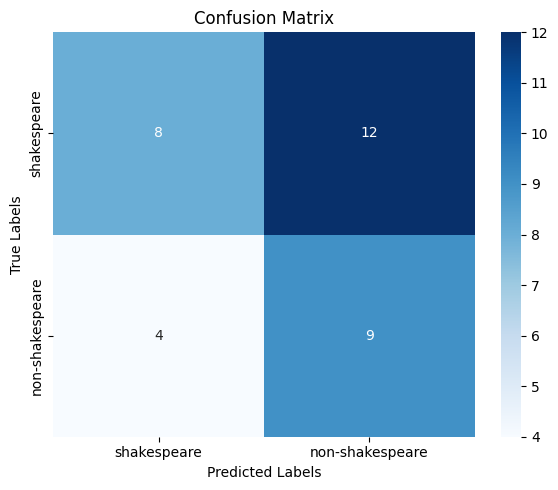

                 precision    recall  f1-score   support

    shakespeare       0.43      0.69      0.53        13
non-shakespeare       0.67      0.40      0.50        20

       accuracy                           0.52        33
      macro avg       0.55      0.55      0.51        33
   weighted avg       0.57      0.52      0.51        33



In [5]:
import numpy as np
import pandas as pd
import random
import math
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

UNK = "<UNK>"
threshold = 2
train_ratio = 0.8
k_smoothing = 0.001

def split_data(filepath, train_ratio=0.8):
    with open(filepath, "r") as f:
        lines = f.readlines()
    random.shuffle(lines)
    
    # Filter out sentences with 2 or fewer words
    lines = [line for line in lines if len(line.strip().split()) > 1]
    
    split_point = int(len(lines) * train_ratio)
    return lines[:split_point], lines[split_point:]

def count_ngrams(lines):
    unigram_count = {UNK: 0}
    bigram_count = {}
    for line in lines:
        tokens = line.strip().split()
        for i, token in enumerate(tokens):
            unigram_count[token] = unigram_count.get(token, 0) + 1
            if i > 0:
                bigram = (tokens[i - 1], token)
                bigram_count[bigram] = bigram_count.get(bigram, 0) + 1
    return unigram_count, bigram_count

def prune_ngrams(unigram_count, bigram_count, threshold):
    for token, count in list(unigram_count.items()):
        if count < threshold and token != UNK:
            unigram_count[UNK] += count
            del unigram_count[token]

    for bigram, count in list(bigram_count.items()):
        w1, w2 = bigram
        new_bigram = (
            w1 if w1 in unigram_count else UNK,
            w2 if w2 in unigram_count else UNK
        )
        if new_bigram != bigram:
            bigram_count[new_bigram] = bigram_count.get(new_bigram, 0) + count
            del bigram_count[bigram]

    return unigram_count, bigram_count

def sentence_log_prob(sentence, unigram_count, bigram_count, total_unigrams, vocab_size, k=0.001):
    log_prob = 0.0
    for i in range(1, len(sentence)):
        w1 = sentence[i - 1] if sentence[i - 1] in unigram_count else UNK
        w2 = sentence[i] if sentence[i] in unigram_count else UNK
        count_unigram = unigram_count.get(w1, 0)
        count_bigram = bigram_count.get((w1, w2), 0)
        # Calculate smoothed probability for the bigram
        prob = (count_bigram + k) / (count_unigram + k * vocab_size)
        log_prob += math.log(prob)
    return log_prob
    # # Convert log_prob back to probability using exponentiation
    # # Use max(1e-10, prob) to avoid numerical issues (values too small to compute reliably)
    # prob = math.exp(log_prob) if log_prob != float("-inf") else 0.0
    # return max(prob, 1e-10)  # Ensure a small minimum probability to avoid 0.0

def softmax_confidence(log_p1, log_p2):
    # log-sum-exp trick to avoid underflow
    max_log = max(log_p1, log_p2)
    sum_exp = math.exp(log_p1 - max_log) + math.exp(log_p2 - max_log)
    log_sum = max_log + math.log(sum_exp)

    # compute softmax probability for the predicted class
    conf1 = math.exp(log_p1 - log_sum)
    conf2 = math.exp(log_p2 - log_sum)
    return max(conf1, conf2)

def build_model(lines, threshold):
    unigram_count, bigram_count = count_ngrams(lines)
    unigram_count, bigram_count = prune_ngrams(unigram_count, bigram_count, threshold)
    total_unigrams = sum(unigram_count.values())
    vocab_size = len(unigram_count)
    return unigram_count, bigram_count, total_unigrams, vocab_size

# # Split datasets (now filtering out sentences with 2 or fewer words)
# shake_train, shake_test = split_data("shakespeare.csv", train_ratio)
# nshake_train, nshake_test = split_data("cleanNonShake.csv", train_ratio)

# print(shake_train[:10])
# print(nshake_train[:10])

train_df = pd.read_csv('dataset/train_data.csv')
val_df = pd.read_csv('dataset/val_data.csv')

shake_train = train_df[train_df['label'] == 1]['text'].tolist()
nshake_train = train_df[train_df['label'] == 0]['text'].tolist()

shake_test = val_df[val_df['label'] == 1]['text'].tolist()
nshake_test = val_df[val_df['label'] == 0]['text'].tolist()

# Train models
shake_uni, shake_bi, shake_total, shake_vocab = build_model(shake_train, threshold)
nshake_uni, nshake_bi, nshake_total, nshake_vocab = build_model(nshake_train, threshold)

def evaluate_full_test_set_with_confidence(shake_test, nshake_test):
    y_true = []
    y_pred = []
    confidences = []
    margin = -4.0

    # Shakespeare test samples
    for line in shake_test:
        sentence = line.split()
        # if len(sentence) < 2:
        #     continue
        p_shake = sentence_log_prob(sentence, shake_uni, shake_bi, shake_total, shake_vocab, k_smoothing)
        p_nshake = sentence_log_prob(sentence, nshake_uni, nshake_bi, nshake_total, nshake_vocab, k_smoothing)
        predicted = "shakespeare" if p_shake > p_nshake + margin else "non-shakespeare"
        confidence = softmax_confidence(p_shake, p_nshake)
        y_true.append("shakespeare")
        y_pred.append(predicted)
        confidences.append(confidence)

    # Non-Shakespeare test samples
    for line in nshake_test:
        sentence = line.split()
        # if len(sentence) < 2:
        #     continue
        p_shake = sentence_log_prob(sentence, shake_uni, shake_bi, shake_total, shake_vocab, k_smoothing)
        p_nshake = sentence_log_prob(sentence, nshake_uni, nshake_bi, nshake_total, nshake_vocab, k_smoothing)
        predicted = "shakespeare" if p_shake > p_nshake + margin else "non-shakespeare"
        confidence = softmax_confidence(p_shake, p_nshake)
        y_true.append("non-shakespeare")
        y_pred.append(predicted)
        confidences.append(confidence)

    # Confusion Matrix
    labels = ["shakespeare", "non-shakespeare"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plotting the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred, target_names=["shakespeare", "non-shakespeare"]))

# Evaluate the test set with confidence
evaluate_full_test_set_with_confidence(shake_test, nshake_test)


In [6]:
def naive_evaluate():
    test_df = pd.read_csv('dataset/test_data.csv')

    actual_labels, predictions, probabilities = [], [], []
    for i in range(len(test_df)):
        sentence = test_df['text'][i].split()
        p_shake = sentence_log_prob(sentence, shake_uni, shake_bi, shake_total, shake_vocab, k_smoothing)
        p_nshake = sentence_log_prob(sentence, nshake_uni, nshake_bi, nshake_total, nshake_vocab, k_smoothing)
        confidence = softmax_confidence(p_shake, p_nshake)
        predicted = 1 if p_shake > p_nshake else 0
        actual_labels.append(test_df['label'][i])
        predictions.append(predicted)
        probabilities.append(confidence)

    return actual_labels, predictions, probabilities

In [9]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

actual_labels, predictions, probabilities = naive_evaluate()

eval_data = {}
eval_data['NAIVE'] = {
    'accuracy': accuracy_score(actual_labels, predictions),
    'f1_score': f1_score(actual_labels, predictions),
    'auc_score': roc_auc_score(actual_labels, probabilities),
    'roc_score': roc_curve(actual_labels, probabilities),
    'labels': actual_labels,
    'predictions': predictions
}

In [12]:
import os
import pickle

# Make sure the directory exists
os.makedirs("eval_data", exist_ok=True)

# Now save the file
with open("eval_data/naive.pkl", "wb") as f:
    pickle.dump(eval_data, f)

In [14]:
auc_score = eval_data['NAIVE']['auc_score']
fpr_data, tpr_data = eval_data['NAIVE']['roc_score'][:-1]
roc_data = [(auc_score, fpr_data, tpr_data, 'NAIVE')]
print('F1 Score:', eval_data['NAIVE']['f1_score'])
print('Accuracy:', eval_data['NAIVE']['accuracy'])


NameError: name 'y_true' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4cd1bb92-5c33-4c71-9500-71d9821d29e2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>